In [2]:
import numpy as np
import xarray as xa
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# Data Cleanup and Preparation

This script coarsens the data, calculates a distance matrix for grid-cells and stores some other re-usable information (latitude and longitude values of the flattened grid, onset indices of the winter seasons)

### Downsampling

The data is sampled down to a 25x40 grid with trimmed boundaries when there are too many individual time series. Each cell is thus the average of 64 cells from the original data.

The temporal resolution is reduced to weekly to further reduce computation time and denoise the data.

In [3]:
ds = xa.open_dataset("../data/2m_temperature_Europe_1981-2020_daily.nc", chunks={"latitude": 25, "longitude": 38})

In [5]:
coarsened = ds.coarsen(latitude=8, longitude=8, boundary='trim').mean()
coarsened = coarsened.compute()
coarsened.to_netcdf("../data/data_downsampled.nc")

In [13]:
# load daily time series
ds_daily  = xa.open_dataset("../data/data_downsampled.nc").t2m
# take mean over weeks
ds_weekly = ds_daily.resample(time="1W").mean()
# take only winter months
ds_weekly = ds_weekly[(ds_weekly.time.dt.month >= 10) | (ds_weekly.time.dt.month <= 3)]
ds_weekly.shape

(1042, 25, 40)

In [29]:
# store the data as both netcdf and numpy array
ds_weekly.to_netcdf("../data/data_downsampled_binned.nc")

# re-organize into 25x40=1000 time series
time_series = ds_weekly.to_numpy().reshape((len(ds_weekly.time), -1)).T
# store data with numpy
np.save("../data/data_downsampled_binned", time_series)

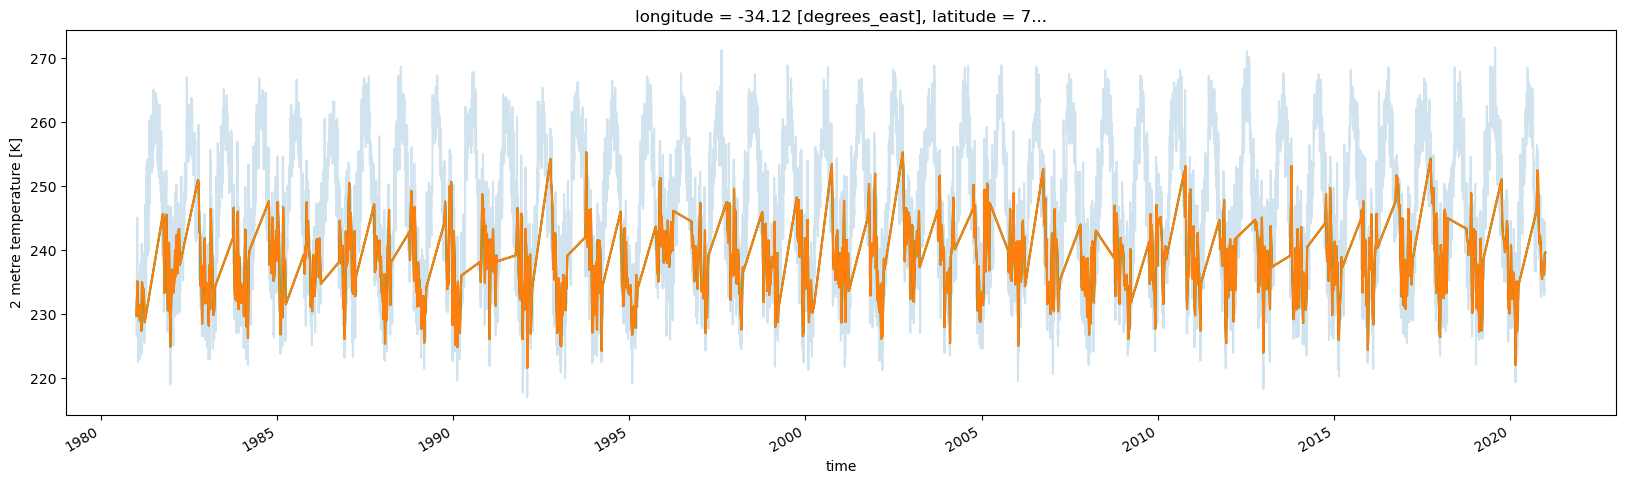

In [27]:
plt.figure(figsize=(20, 5))
ds_daily[:,0,0].plot(alpha=0.2)

# when you see no green, the numpy reorganization worked flawlessly
ds_weekly[:,0,0].plot(c="green")
plt.plot(ds_weekly.time, time_series[0])

plt.show()

### Distance Matrix

The distance matrix is once calculated as the great circle distance between grid cells. Great circle distances are exceptionally faster than geodesic ones and because the data covers only a fraction of the Earth, the error is relatively small.

During the calculation, the latitude and longitude coordinates of the data, as well as the gridded version are also stored so they can be easily used later.

In [34]:
import itertools
import quasibi
from geopy.distance import great_circle

In [29]:
ds_weekly = xa.load_dataset("../data/data_downsampled_binned.nc")

# store latitude and longitude of the data
LAT, LON = ds_weekly.latitude, ds_weekly.longitude
np.savez("../output/latlon", latitude=LAT, longitude=LON)

# store latitude and longitude of the nodes
LAT, LON = np.meshgrid(ds_weekly.latitude, ds_weekly.longitude, indexing="ij")
LAT, LON = LAT.flatten(), LON.flatten()
np.savez("../output/latlon_nodes", latitude=LAT, longitude=LON)

In [47]:
# calculate distance matrix
D = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        if i > j:
            D[i, j] = great_circle((LAT[i], LON[i]), (LAT[j], LON[j])).km
D = D + D.T

# store the result
quasibi.save_symmat(D, "../output/distance")

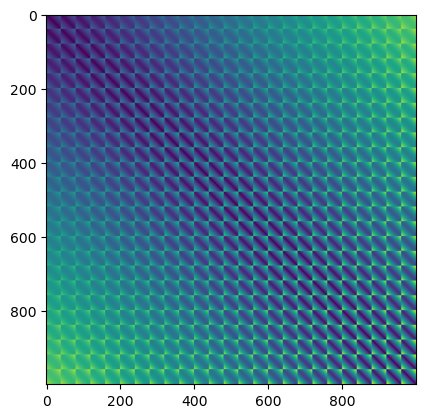

In [45]:
plt.imshow(D)

### Winter Onset Indices

The winter onset indices are based on the first time index that falls into October. Due to variable length of years, they are roughly spaced every 25-26 weeks (start of October to end of March).

The first two winter seasons are only 13 weeks long, as the data starts in January and ends in December.

In [3]:
ds_weekly = xa.open_dataset("../data/data_downsampled_binned.nc")

# indices in the time series for winter onset
onset_indices = np.arange(len(ds_weekly.time))[ds_weekly.time.dt.isocalendar().week == 40]
onset_indices = np.insert(onset_indices, 0, 0)
onset_indices = np.append(onset_indices, len(ds_weekly.time) - 1)

# store them for later use
np.save("../output/onset_indices", onset_indices)

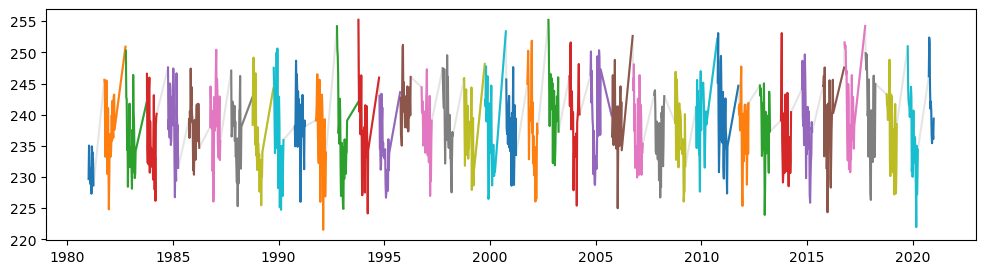

In [4]:
plt.figure(figsize=(12, 3))
plt.plot(ds_weekly.time, ds_weekly.t2m[:, 0, 0], c="gray", alpha=0.2)

for i, j in zip(onset_indices[:-1], onset_indices[1:]):
	plt.plot(ds_weekly.time[i:j], ds_weekly.t2m[i:j, 0, 0])